In [1]:
import xarray as xr
import numpy as np
import rioxarray  # Import rioxarray for GeoTIFF export
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.array as da

In [3]:
import os

# Get the current working directory (optional)
current_directory = os.getcwd()
print(f"Current directory: {current_directory}")

# Define the new directory path
new_directory = "I:/loca2/gen_use"  # Replace with your desired path

# Change the directory
try:
    os.chdir(new_directory)
    print(f"Successfully changed directory to: {os.getcwd()}")
except FileNotFoundError:
    print(f"Error: The directory '{new_directory}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Current directory: C:\Users\Ben
Successfully changed directory to: I:\loca2\gen_use


In [5]:
def calculate_tasmax_difference_f_first_dask(hist_file, mid_file, output_file="VCP_DROUGHT_TMAXJJA_Warming_2015-2044_ACCESS-CM2.nc"):
    """
    Calculates the difference in average tasmax between two NetCDF files (hist.nc and mid.nc)
    after converting tasmax to Fahrenheit first, using dask for lazy evaluation.

    Args:
        hist_file (str): Path to the hist.nc file.
        mid_file (str): Path to the mid.nc file.
        output_file (str): Path to save the resulting NetCDF file.
    """
    try:
        hist_ds = xr.open_dataset(hist_file, chunks={'time': 'auto'}) #enable chunking
        mid_ds = xr.open_dataset(mid_file, chunks={'time': 'auto'}) #enable chunking

        # Select June, July, and August
        jja_mask = hist_ds['time.month'].isin([6, 7, 8])
        hist_ds = hist_ds.sel(time=jja_mask)
        jja_mask = mid_ds['time.month'].isin([6, 7, 8])
        mid_ds = mid_ds.sel(time=jja_mask)
        
        hist_tasmax = hist_ds["tasmax"]
        mid_tasmax = mid_ds["tasmax"]

        # Convert Kelvin to Fahrenheit: (K - 273.15) * 9/5 + 32
        hist_tasmax_f = (hist_tasmax - 273.15) * 9/5 + 32
        mid_tasmax_f = (mid_tasmax - 273.15) * 9/5 + 32

        # Calculate the average tasmax in Fahrenheit over the time dimension
        hist_avg_f = hist_tasmax_f.mean(dim="time")
        mid_avg_f = mid_tasmax_f.mean(dim="time")

        # Calculate the difference (mid - hist) in Fahrenheit
        diff_f = mid_avg_f - hist_avg_f

        # Create a new xarray DataArray with the Fahrenheit difference values
        diff_f_da = xr.DataArray(
            diff_f,
            coords=diff_f.coords,  # Copy coordinates from the original difference
            dims=diff_f.dims,
            attrs={"units": "degrees Fahrenheit", "description": "Difference in average tasmax (mid - hist) in Fahrenheit (conversion first)"},
        )

        # Create a new Dataset and save it to a NetCDF file
        diff_ds = xr.Dataset({"tasmax": diff_f_da})
        diff_ds.to_netcdf(output_file)

        print(f"Difference in average tasmax (F, conversion first) saved to {output_file}")

    except FileNotFoundError:
        print("Error: One or both files not found.")
    except KeyError:
        print("Error: 'tasmax' variable not found in one or both files.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'hist_ds' in locals():
            hist_ds.close()
        if 'mid_ds' in locals():
            mid_ds.close()

# Example usage:
hist_file_path = "tasmax.ACCESS-CM2.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"  # Replace with the actual path
mid_file_path = "tasmax.ACCESS-CM2.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"    # Replace with the actual path

calculate_tasmax_difference_f_first_dask(hist_file_path, mid_file_path)

C:\Users\Ben\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\Ben\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\Ben\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Difference in average tasmax (F, conversion first) saved to VCP_DROUGHT_TMAXJJA_Warming_2015-2044_ACCESS-CM2.nc


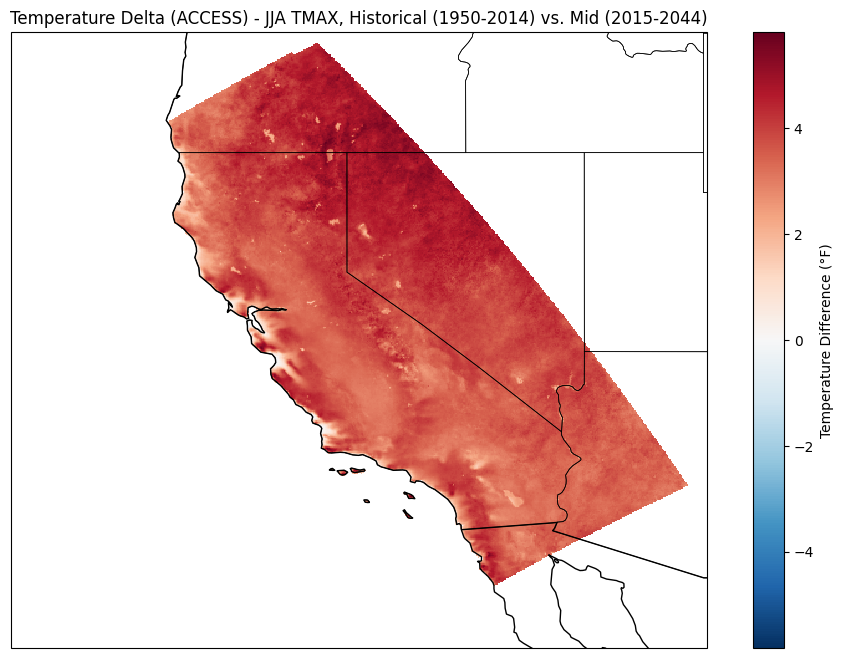

In [6]:
def map_tasmax_difference(netcdf_file, variable_name="tasmax", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the tasmax difference from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the tasmax difference.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax_diff_fahrenheit".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'label': 'Temperature Difference (°F)'})

        plt.title("Temperature Delta (ACCESS) - JJA TMAX, Historical (1950-2014) vs. Mid (2015-2044)")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_DROUGHT_TMAXJJA_Warming_2015-2044_ACCESS-CM2.nc"  # Path to the NetCDF file with the tasmax difference

map_tasmax_difference(netcdf_file_path)

In [7]:
def calculate_tasmax_difference_f_first_dask(hist_file, mid_file, output_file="VCP_DROUGHT_TMAXJJA_Warming_2045-2074_ACCESS-CM2.nc"):
    """
    Calculates the difference in average tasmax between two NetCDF files (hist.nc and mid.nc)
    after converting tasmax to Fahrenheit first, using dask for lazy evaluation.

    Args:
        hist_file (str): Path to the hist.nc file.
        mid_file (str): Path to the mid.nc file.
        output_file (str): Path to save the resulting NetCDF file.
    """
    try:
        hist_ds = xr.open_dataset(hist_file, chunks={'time': 'auto'}) #enable chunking
        mid_ds = xr.open_dataset(mid_file, chunks={'time': 'auto'}) #enable chunking

        # Select June, July, and August
        jja_mask = hist_ds['time.month'].isin([6, 7, 8])
        hist_ds = hist_ds.sel(time=jja_mask)
        jja_mask = mid_ds['time.month'].isin([6, 7, 8])
        mid_ds = mid_ds.sel(time=jja_mask)
        
        hist_tasmax = hist_ds["tasmax"]
        mid_tasmax = mid_ds["tasmax"]

        # Convert Kelvin to Fahrenheit: (K - 273.15) * 9/5 + 32
        hist_tasmax_f = (hist_tasmax - 273.15) * 9/5 + 32
        mid_tasmax_f = (mid_tasmax - 273.15) * 9/5 + 32

        # Calculate the average tasmax in Fahrenheit over the time dimension
        hist_avg_f = hist_tasmax_f.mean(dim="time")
        mid_avg_f = mid_tasmax_f.mean(dim="time")

        # Calculate the difference (mid - hist) in Fahrenheit
        diff_f = mid_avg_f - hist_avg_f

        # Create a new xarray DataArray with the Fahrenheit difference values
        diff_f_da = xr.DataArray(
            diff_f,
            coords=diff_f.coords,  # Copy coordinates from the original difference
            dims=diff_f.dims,
            attrs={"units": "degrees Fahrenheit", "description": "Difference in average tasmax (late - hist) in Fahrenheit (conversion first)"},
        )

        # Create a new Dataset and save it to a NetCDF file
        diff_ds = xr.Dataset({"tasmax": diff_f_da})
        diff_ds.to_netcdf(output_file)

        print(f"Difference in average tasmax (F, conversion first) saved to {output_file}")

    except FileNotFoundError:
        print("Error: One or both files not found.")
    except KeyError:
        print("Error: 'tasmax' variable not found in one or both files.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'hist_ds' in locals():
            hist_ds.close()
        if 'mid_ds' in locals():
            mid_ds.close()

# Example usage:
hist_file_path = "tasmax.ACCESS-CM2.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"  # Replace with the actual path
mid_file_path = "tasmax.ACCESS-CM2.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"    # Replace with the actual path

calculate_tasmax_difference_f_first_dask(hist_file_path, mid_file_path)

Difference in average tasmax (F, conversion first) saved to VCP_DROUGHT_TMAXJJA_Warming_2045-2074_ACCESS-CM2.nc


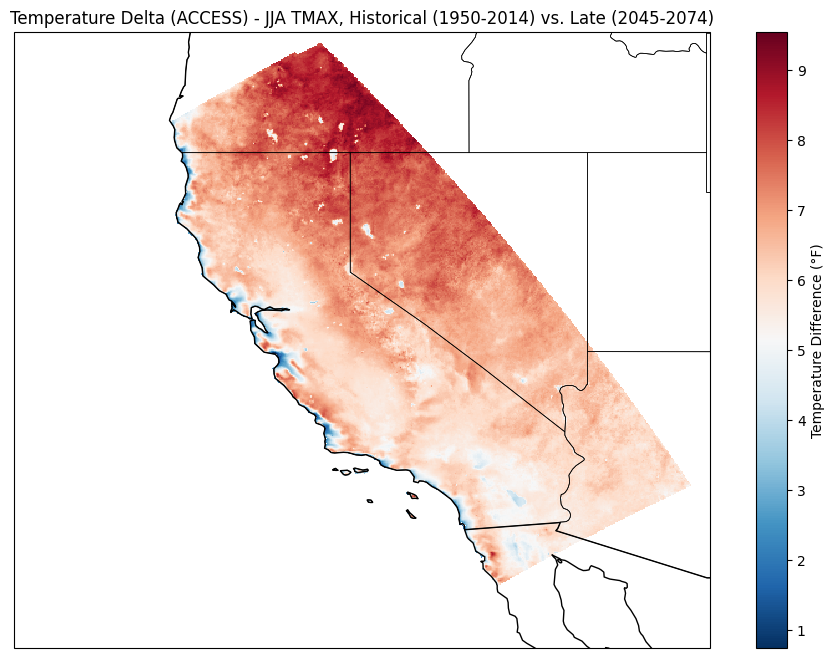

In [8]:
def map_tasmax_difference(netcdf_file, variable_name="tasmax", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the tasmax difference from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the tasmax difference.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax_diff_fahrenheit".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'label': 'Temperature Difference (°F)'})

        plt.title("Temperature Delta (ACCESS) - JJA TMAX, Historical (1950-2014) vs. Late (2045-2074)")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_DROUGHT_TMAXJJA_Warming_2045-2074_ACCESS-CM2.nc"  # Path to the NetCDF file with the tasmax difference

map_tasmax_difference(netcdf_file_path)

In [13]:
def calculate_tasmax_difference_f_first_dask(hist_file, mid_file, output_file="VCP_DROUGHT_TMAXJJA_Warming_2015-2044_Earth3.nc"):
    """
    Calculates the difference in average tasmax between two NetCDF files (hist.nc and mid.nc)
    after converting tasmax to Fahrenheit first, using dask for lazy evaluation.

    Args:
        hist_file (str): Path to the hist.nc file.
        mid_file (str): Path to the mid.nc file.
        output_file (str): Path to save the resulting NetCDF file.
    """
    try:
        hist_ds = xr.open_dataset(hist_file, chunks={'time': 'auto'}) #enable chunking
        mid_ds = xr.open_dataset(mid_file, chunks={'time': 'auto'}) #enable chunking

        # Select June, July, and August
        jja_mask = hist_ds['time.month'].isin([6, 7, 8])
        hist_ds = hist_ds.sel(time=jja_mask)
        jja_mask = mid_ds['time.month'].isin([6, 7, 8])
        mid_ds = mid_ds.sel(time=jja_mask)
        
        hist_tasmax = hist_ds["tasmax"]
        mid_tasmax = mid_ds["tasmax"]

        # Convert Kelvin to Fahrenheit: (K - 273.15) * 9/5 + 32
        hist_tasmax_f = (hist_tasmax - 273.15) * 9/5 + 32
        mid_tasmax_f = (mid_tasmax - 273.15) * 9/5 + 32

        # Calculate the average tasmax in Fahrenheit over the time dimension
        hist_avg_f = hist_tasmax_f.mean(dim="time")
        mid_avg_f = mid_tasmax_f.mean(dim="time")

        # Calculate the difference (mid - hist) in Fahrenheit
        diff_f = mid_avg_f - hist_avg_f

        # Create a new xarray DataArray with the Fahrenheit difference values
        diff_f_da = xr.DataArray(
            diff_f,
            coords=diff_f.coords,  # Copy coordinates from the original difference
            dims=diff_f.dims,
            attrs={"units": "degrees Fahrenheit", "description": "Difference in average tasmax (mid - hist) in Fahrenheit (conversion first)"},
        )

        # Create a new Dataset and save it to a NetCDF file
        diff_ds = xr.Dataset({"tasmax": diff_f_da})
        diff_ds.to_netcdf(output_file)

        print(f"Difference in average tasmax (F, conversion first) saved to {output_file}")

    except FileNotFoundError:
        print("Error: One or both files not found.")
    except KeyError:
        print("Error: 'tasmax' variable not found in one or both files.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'hist_ds' in locals():
            hist_ds.close()
        if 'mid_ds' in locals():
            mid_ds.close()

# Example usage:
hist_file_path = "tasmax.EC-Earth3.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"  # Replace with the actual path
mid_file_path = "tasmax.EC-Earth3.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"    # Replace with the actual path

calculate_tasmax_difference_f_first_dask(hist_file_path, mid_file_path)

Difference in average tasmax (F, conversion first) saved to VCP_DROUGHT_TMAXJJA_Warming_2015-2044_EC-Earth3.nc


In [14]:
def calculate_tasmax_difference_f_first_dask(hist_file, mid_file, output_file="VCP_DROUGHT_TMAXJJA_Warming_2045-2074_Earth3.nc"):
    """
    Calculates the difference in average tasmax between two NetCDF files (hist.nc and mid.nc)
    after converting tasmax to Fahrenheit first, using dask for lazy evaluation.

    Args:
        hist_file (str): Path to the hist.nc file.
        mid_file (str): Path to the mid.nc file.
        output_file (str): Path to save the resulting NetCDF file.
    """
    try:
        hist_ds = xr.open_dataset(hist_file, chunks={'time': 'auto'}) #enable chunking
        mid_ds = xr.open_dataset(mid_file, chunks={'time': 'auto'}) #enable chunking

        # Select June, July, and August
        jja_mask = hist_ds['time.month'].isin([6, 7, 8])
        hist_ds = hist_ds.sel(time=jja_mask)
        jja_mask = mid_ds['time.month'].isin([6, 7, 8])
        mid_ds = mid_ds.sel(time=jja_mask)
        
        hist_tasmax = hist_ds["tasmax"]
        mid_tasmax = mid_ds["tasmax"]

        # Convert Kelvin to Fahrenheit: (K - 273.15) * 9/5 + 32
        hist_tasmax_f = (hist_tasmax - 273.15) * 9/5 + 32
        mid_tasmax_f = (mid_tasmax - 273.15) * 9/5 + 32

        # Calculate the average tasmax in Fahrenheit over the time dimension
        hist_avg_f = hist_tasmax_f.mean(dim="time")
        mid_avg_f = mid_tasmax_f.mean(dim="time")

        # Calculate the difference (mid - hist) in Fahrenheit
        diff_f = mid_avg_f - hist_avg_f

        # Create a new xarray DataArray with the Fahrenheit difference values
        diff_f_da = xr.DataArray(
            diff_f,
            coords=diff_f.coords,  # Copy coordinates from the original difference
            dims=diff_f.dims,
            attrs={"units": "degrees Fahrenheit", "description": "Difference in average tasmax (mid - hist) in Fahrenheit (conversion first)"},
        )

        # Create a new Dataset and save it to a NetCDF file
        diff_ds = xr.Dataset({"tasmax": diff_f_da})
        diff_ds.to_netcdf(output_file)

        print(f"Difference in average tasmax (F, conversion first) saved to {output_file}")

    except FileNotFoundError:
        print("Error: One or both files not found.")
    except KeyError:
        print("Error: 'tasmax' variable not found in one or both files.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'hist_ds' in locals():
            hist_ds.close()
        if 'mid_ds' in locals():
            mid_ds.close()

# Example usage:
hist_file_path = "tasmax.EC-Earth3.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"  # Replace with the actual path
mid_file_path = "tasmax.EC-Earth3.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"    # Replace with the actual path

calculate_tasmax_difference_f_first_dask(hist_file_path, mid_file_path)

Difference in average tasmax (F, conversion first) saved to VCP_DROUGHT_TMAXJJA_Warming_2045-2074_Earth3.nc


In [15]:
def calculate_tasmax_difference_f_first_dask(hist_file, mid_file, output_file="VCP_DROUGHT_TMAXJJA_Warming_2015-2044_FGOALS.nc"):
    """
    Calculates the difference in average tasmax between two NetCDF files (hist.nc and mid.nc)
    after converting tasmax to Fahrenheit first, using dask for lazy evaluation.

    Args:
        hist_file (str): Path to the hist.nc file.
        mid_file (str): Path to the mid.nc file.
        output_file (str): Path to save the resulting NetCDF file.
    """
    try:
        hist_ds = xr.open_dataset(hist_file, chunks={'time': 'auto'}) #enable chunking
        mid_ds = xr.open_dataset(mid_file, chunks={'time': 'auto'}) #enable chunking

        # Select June, July, and August
        jja_mask = hist_ds['time.month'].isin([6, 7, 8])
        hist_ds = hist_ds.sel(time=jja_mask)
        jja_mask = mid_ds['time.month'].isin([6, 7, 8])
        mid_ds = mid_ds.sel(time=jja_mask)
        
        hist_tasmax = hist_ds["tasmax"]
        mid_tasmax = mid_ds["tasmax"]

        # Convert Kelvin to Fahrenheit: (K - 273.15) * 9/5 + 32
        hist_tasmax_f = (hist_tasmax - 273.15) * 9/5 + 32
        mid_tasmax_f = (mid_tasmax - 273.15) * 9/5 + 32

        # Calculate the average tasmax in Fahrenheit over the time dimension
        hist_avg_f = hist_tasmax_f.mean(dim="time")
        mid_avg_f = mid_tasmax_f.mean(dim="time")

        # Calculate the difference (mid - hist) in Fahrenheit
        diff_f = mid_avg_f - hist_avg_f

        # Create a new xarray DataArray with the Fahrenheit difference values
        diff_f_da = xr.DataArray(
            diff_f,
            coords=diff_f.coords,  # Copy coordinates from the original difference
            dims=diff_f.dims,
            attrs={"units": "degrees Fahrenheit", "description": "Difference in average tasmax (mid - hist) in Fahrenheit (conversion first)"},
        )

        # Create a new Dataset and save it to a NetCDF file
        diff_ds = xr.Dataset({"tasmax": diff_f_da})
        diff_ds.to_netcdf(output_file)

        print(f"Difference in average tasmax (F, conversion first) saved to {output_file}")

    except FileNotFoundError:
        print("Error: One or both files not found.")
    except KeyError:
        print("Error: 'tasmax' variable not found in one or both files.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'hist_ds' in locals():
            hist_ds.close()
        if 'mid_ds' in locals():
            mid_ds.close()

# Example usage:
hist_file_path = "tasmax.FGOALS-g3.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"  # Replace with the actual path
mid_file_path = "tasmax.FGOALS-g3.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"    # Replace with the actual path

calculate_tasmax_difference_f_first_dask(hist_file_path, mid_file_path)

Difference in average tasmax (F, conversion first) saved to VCP_DROUGHT_TMAXJJA_Warming_2015-2044_FGOALS.nc


In [17]:
def calculate_tasmax_difference_f_first_dask(hist_file, mid_file, output_file="VCP_DROUGHT_TMAXJJA_Warming_2045-2074_FGOALS.nc"):
    """
    Calculates the difference in average tasmax between two NetCDF files (hist.nc and mid.nc)
    after converting tasmax to Fahrenheit first, using dask for lazy evaluation.

    Args:
        hist_file (str): Path to the hist.nc file.
        mid_file (str): Path to the mid.nc file.
        output_file (str): Path to save the resulting NetCDF file.
    """
    try:
        hist_ds = xr.open_dataset(hist_file, chunks={'time': 'auto'}) #enable chunking
        mid_ds = xr.open_dataset(mid_file, chunks={'time': 'auto'}) #enable chunking

        # Select June, July, and August
        jja_mask = hist_ds['time.month'].isin([6, 7, 8])
        hist_ds = hist_ds.sel(time=jja_mask)
        jja_mask = mid_ds['time.month'].isin([6, 7, 8])
        mid_ds = mid_ds.sel(time=jja_mask)
        
        hist_tasmax = hist_ds["tasmax"]
        mid_tasmax = mid_ds["tasmax"]

        # Convert Kelvin to Fahrenheit: (K - 273.15) * 9/5 + 32
        hist_tasmax_f = (hist_tasmax - 273.15) * 9/5 + 32
        mid_tasmax_f = (mid_tasmax - 273.15) * 9/5 + 32

        # Calculate the average tasmax in Fahrenheit over the time dimension
        hist_avg_f = hist_tasmax_f.mean(dim="time")
        mid_avg_f = mid_tasmax_f.mean(dim="time")

        # Calculate the difference (mid - hist) in Fahrenheit
        diff_f = mid_avg_f - hist_avg_f

        # Create a new xarray DataArray with the Fahrenheit difference values
        diff_f_da = xr.DataArray(
            diff_f,
            coords=diff_f.coords,  # Copy coordinates from the original difference
            dims=diff_f.dims,
            attrs={"units": "degrees Fahrenheit", "description": "Difference in average tasmax (mid - hist) in Fahrenheit (conversion first)"},
        )

        # Create a new Dataset and save it to a NetCDF file
        diff_ds = xr.Dataset({"tasmax": diff_f_da})
        diff_ds.to_netcdf(output_file)

        print(f"Difference in average tasmax (F, conversion first) saved to {output_file}")

    except FileNotFoundError:
        print("Error: One or both files not found.")
    except KeyError:
        print("Error: 'tasmax' variable not found in one or both files.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'hist_ds' in locals():
            hist_ds.close()
        if 'mid_ds' in locals():
            mid_ds.close()

# Example usage:
hist_file_path = "tasmax.FGOALS-g3.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"  # Replace with the actual path
mid_file_path = "tasmax.FGOALS-g3.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"    # Replace with the actual path

calculate_tasmax_difference_f_first_dask(hist_file_path, mid_file_path)

Difference in average tasmax (F, conversion first) saved to VCP_DROUGHT_TMAXJJA_Warming_2045-2074_FGOALS.nc


In [18]:
def calculate_tasmax_difference_f_first_dask(hist_file, mid_file, output_file="VCP_DROUGHT_TMAXJJA_Warming_2015-2044_MIROC6.nc"):
    """
    Calculates the difference in average tasmax between two NetCDF files (hist.nc and mid.nc)
    after converting tasmax to Fahrenheit first, using dask for lazy evaluation.

    Args:
        hist_file (str): Path to the hist.nc file.
        mid_file (str): Path to the mid.nc file.
        output_file (str): Path to save the resulting NetCDF file.
    """
    try:
        hist_ds = xr.open_dataset(hist_file, chunks={'time': 'auto'}) #enable chunking
        mid_ds = xr.open_dataset(mid_file, chunks={'time': 'auto'}) #enable chunking

        # Select June, July, and August
        jja_mask = hist_ds['time.month'].isin([6, 7, 8])
        hist_ds = hist_ds.sel(time=jja_mask)
        jja_mask = mid_ds['time.month'].isin([6, 7, 8])
        mid_ds = mid_ds.sel(time=jja_mask)
        
        hist_tasmax = hist_ds["tasmax"]
        mid_tasmax = mid_ds["tasmax"]

        # Convert Kelvin to Fahrenheit: (K - 273.15) * 9/5 + 32
        hist_tasmax_f = (hist_tasmax - 273.15) * 9/5 + 32
        mid_tasmax_f = (mid_tasmax - 273.15) * 9/5 + 32

        # Calculate the average tasmax in Fahrenheit over the time dimension
        hist_avg_f = hist_tasmax_f.mean(dim="time")
        mid_avg_f = mid_tasmax_f.mean(dim="time")

        # Calculate the difference (mid - hist) in Fahrenheit
        diff_f = mid_avg_f - hist_avg_f

        # Create a new xarray DataArray with the Fahrenheit difference values
        diff_f_da = xr.DataArray(
            diff_f,
            coords=diff_f.coords,  # Copy coordinates from the original difference
            dims=diff_f.dims,
            attrs={"units": "degrees Fahrenheit", "description": "Difference in average tasmax (mid - hist) in Fahrenheit (conversion first)"},
        )

        # Create a new Dataset and save it to a NetCDF file
        diff_ds = xr.Dataset({"tasmax": diff_f_da})
        diff_ds.to_netcdf(output_file)

        print(f"Difference in average tasmax (F, conversion first) saved to {output_file}")

    except FileNotFoundError:
        print("Error: One or both files not found.")
    except KeyError:
        print("Error: 'tasmax' variable not found in one or both files.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'hist_ds' in locals():
            hist_ds.close()
        if 'mid_ds' in locals():
            mid_ds.close()

# Example usage:
hist_file_path = "tasmax.MIROC6.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"  # Replace with the actual path
mid_file_path = "tasmax.MIROC6.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"    # Replace with the actual path

calculate_tasmax_difference_f_first_dask(hist_file_path, mid_file_path)

Difference in average tasmax (F, conversion first) saved to VCP_DROUGHT_TMAXJJA_Warming_2015-2044_MIROC6.nc


In [19]:
def calculate_tasmax_difference_f_first_dask(hist_file, mid_file, output_file="VCP_DROUGHT_TMAXJJA_Warming_2045-2074_MIROC6.nc"):
    """
    Calculates the difference in average tasmax between two NetCDF files (hist.nc and mid.nc)
    after converting tasmax to Fahrenheit first, using dask for lazy evaluation.

    Args:
        hist_file (str): Path to the hist.nc file.
        mid_file (str): Path to the mid.nc file.
        output_file (str): Path to save the resulting NetCDF file.
    """
    try:
        hist_ds = xr.open_dataset(hist_file, chunks={'time': 'auto'}) #enable chunking
        mid_ds = xr.open_dataset(mid_file, chunks={'time': 'auto'}) #enable chunking

        # Select June, July, and August
        jja_mask = hist_ds['time.month'].isin([6, 7, 8])
        hist_ds = hist_ds.sel(time=jja_mask)
        jja_mask = mid_ds['time.month'].isin([6, 7, 8])
        mid_ds = mid_ds.sel(time=jja_mask)
        
        hist_tasmax = hist_ds["tasmax"]
        mid_tasmax = mid_ds["tasmax"]

        # Convert Kelvin to Fahrenheit: (K - 273.15) * 9/5 + 32
        hist_tasmax_f = (hist_tasmax - 273.15) * 9/5 + 32
        mid_tasmax_f = (mid_tasmax - 273.15) * 9/5 + 32

        # Calculate the average tasmax in Fahrenheit over the time dimension
        hist_avg_f = hist_tasmax_f.mean(dim="time")
        mid_avg_f = mid_tasmax_f.mean(dim="time")

        # Calculate the difference (mid - hist) in Fahrenheit
        diff_f = mid_avg_f - hist_avg_f

        # Create a new xarray DataArray with the Fahrenheit difference values
        diff_f_da = xr.DataArray(
            diff_f,
            coords=diff_f.coords,  # Copy coordinates from the original difference
            dims=diff_f.dims,
            attrs={"units": "degrees Fahrenheit", "description": "Difference in average tasmax (mid - hist) in Fahrenheit (conversion first)"},
        )

        # Create a new Dataset and save it to a NetCDF file
        diff_ds = xr.Dataset({"tasmax": diff_f_da})
        diff_ds.to_netcdf(output_file)

        print(f"Difference in average tasmax (F, conversion first) saved to {output_file}")

    except FileNotFoundError:
        print("Error: One or both files not found.")
    except KeyError:
        print("Error: 'tasmax' variable not found in one or both files.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'hist_ds' in locals():
            hist_ds.close()
        if 'mid_ds' in locals():
            mid_ds.close()

# Example usage:
hist_file_path = "tasmax.MIROC6.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"  # Replace with the actual path
mid_file_path = "tasmax.MIROC6.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"    # Replace with the actual path

calculate_tasmax_difference_f_first_dask(hist_file_path, mid_file_path)

Difference in average tasmax (F, conversion first) saved to VCP_DROUGHT_TMAXJJA_Warming_2045-2074_MIROC6.nc


In [21]:
def calculate_tasmax_difference_f_first_dask(hist_file, mid_file, output_file="VCP_DROUGHT_TMAXJJA_Warming_2015-2044_MPI.nc"):
    """
    Calculates the difference in average tasmax between two NetCDF files (hist.nc and mid.nc)
    after converting tasmax to Fahrenheit first, using dask for lazy evaluation.

    Args:
        hist_file (str): Path to the hist.nc file.
        mid_file (str): Path to the mid.nc file.
        output_file (str): Path to save the resulting NetCDF file.
    """
    try:
        hist_ds = xr.open_dataset(hist_file, chunks={'time': 'auto'}) #enable chunking
        mid_ds = xr.open_dataset(mid_file, chunks={'time': 'auto'}) #enable chunking

        # Select June, July, and August
        jja_mask = hist_ds['time.month'].isin([6, 7, 8])
        hist_ds = hist_ds.sel(time=jja_mask)
        jja_mask = mid_ds['time.month'].isin([6, 7, 8])
        mid_ds = mid_ds.sel(time=jja_mask)
        
        hist_tasmax = hist_ds["tasmax"]
        mid_tasmax = mid_ds["tasmax"]

        # Convert Kelvin to Fahrenheit: (K - 273.15) * 9/5 + 32
        hist_tasmax_f = (hist_tasmax - 273.15) * 9/5 + 32
        mid_tasmax_f = (mid_tasmax - 273.15) * 9/5 + 32

        # Calculate the average tasmax in Fahrenheit over the time dimension
        hist_avg_f = hist_tasmax_f.mean(dim="time")
        mid_avg_f = mid_tasmax_f.mean(dim="time")

        # Calculate the difference (mid - hist) in Fahrenheit
        diff_f = mid_avg_f - hist_avg_f

        # Create a new xarray DataArray with the Fahrenheit difference values
        diff_f_da = xr.DataArray(
            diff_f,
            coords=diff_f.coords,  # Copy coordinates from the original difference
            dims=diff_f.dims,
            attrs={"units": "degrees Fahrenheit", "description": "Difference in average tasmax (mid - hist) in Fahrenheit (conversion first)"},
        )

        # Create a new Dataset and save it to a NetCDF file
        diff_ds = xr.Dataset({"tasmax": diff_f_da})
        diff_ds.to_netcdf(output_file)

        print(f"Difference in average tasmax (F, conversion first) saved to {output_file}")

    except FileNotFoundError:
        print("Error: One or both files not found.")
    except KeyError:
        print("Error: 'tasmax' variable not found in one or both files.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'hist_ds' in locals():
            hist_ds.close()
        if 'mid_ds' in locals():
            mid_ds.close()

# Example usage:
hist_file_path = "tasmax.MPI-ESM1-2-HR.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"  # Replace with the actual path
mid_file_path = "tasmax.MPI-ESM1-2-HR.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"    # Replace with the actual path

calculate_tasmax_difference_f_first_dask(hist_file_path, mid_file_path)

Error: One or both files not found.


In [22]:
def calculate_tasmax_difference_f_first_dask(hist_file, mid_file, output_file="VCP_DROUGHT_TMAXJJA_Warming_2045-2074_MPI.nc"):
    """
    Calculates the difference in average tasmax between two NetCDF files (hist.nc and mid.nc)
    after converting tasmax to Fahrenheit first, using dask for lazy evaluation.

    Args:
        hist_file (str): Path to the hist.nc file.
        mid_file (str): Path to the mid.nc file.
        output_file (str): Path to save the resulting NetCDF file.
    """
    try:
        hist_ds = xr.open_dataset(hist_file, chunks={'time': 'auto'}) #enable chunking
        mid_ds = xr.open_dataset(mid_file, chunks={'time': 'auto'}) #enable chunking

        # Select June, July, and August
        jja_mask = hist_ds['time.month'].isin([6, 7, 8])
        hist_ds = hist_ds.sel(time=jja_mask)
        jja_mask = mid_ds['time.month'].isin([6, 7, 8])
        mid_ds = mid_ds.sel(time=jja_mask)
        
        hist_tasmax = hist_ds["tasmax"]
        mid_tasmax = mid_ds["tasmax"]

        # Convert Kelvin to Fahrenheit: (K - 273.15) * 9/5 + 32
        hist_tasmax_f = (hist_tasmax - 273.15) * 9/5 + 32
        mid_tasmax_f = (mid_tasmax - 273.15) * 9/5 + 32

        # Calculate the average tasmax in Fahrenheit over the time dimension
        hist_avg_f = hist_tasmax_f.mean(dim="time")
        mid_avg_f = mid_tasmax_f.mean(dim="time")

        # Calculate the difference (mid - hist) in Fahrenheit
        diff_f = mid_avg_f - hist_avg_f

        # Create a new xarray DataArray with the Fahrenheit difference values
        diff_f_da = xr.DataArray(
            diff_f,
            coords=diff_f.coords,  # Copy coordinates from the original difference
            dims=diff_f.dims,
            attrs={"units": "degrees Fahrenheit", "description": "Difference in average tasmax (mid - hist) in Fahrenheit (conversion first)"},
        )

        # Create a new Dataset and save it to a NetCDF file
        diff_ds = xr.Dataset({"tasmax": diff_f_da})
        diff_ds.to_netcdf(output_file)

        print(f"Difference in average tasmax (F, conversion first) saved to {output_file}")

    except FileNotFoundError:
        print("Error: One or both files not found.")
    except KeyError:
        print("Error: 'tasmax' variable not found in one or both files.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'hist_ds' in locals():
            hist_ds.close()
        if 'mid_ds' in locals():
            mid_ds.close()

# Example usage:
hist_file_path = "tasmax.MPI-ESM1-2-HR.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"  # Replace with the actual path
mid_file_path = "tasmax.MPI-ESM1-2-HR.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"    # Replace with the actual path

calculate_tasmax_difference_f_first_dask(hist_file_path, mid_file_path)

Error: One or both files not found.


In [24]:
import xarray as xr
import glob # For finding files, or you can list them manually
import os

# --- Configuration ---

# 1. Specify the path to your NetCDF files
# Option A: Use a wildcard pattern if your files are in the same directory
file_pattern = "VCP_DROUGHT_TMAXJJA_Warming_2015-2044*.nc" # IMPORTANT: Change this to your actual path and pattern
netcdf_files = sorted(glob.glob(file_pattern))

# Option B: Manually list the file paths
# netcdf_files = [
#     "/path/to/your/files/file1.nc",
#     "/path/to/your/files/file2.nc",
#     "/path/to/your/files/file3.nc",
#     "/path/to/your/files/file4.nc",
#     "/path/to/your/files/file5.nc",
# ] # IMPORTANT: Change these to your actual file paths

# Check if files were found (if using glob)
if not netcdf_files:
    print(f"No files found matching pattern: {file_pattern}")
    print("Or, if manually listing, ensure the list is not empty.")
    # exit() # Or handle as appropriate

print(f"Found files: {netcdf_files}")

# 2. Specify the name of the variable you want to average
# This variable must exist in all your NetCDF files.
variable_name = "tasmax"  # IMPORTANT: Change this (e.g., 'temperature', 'precipitation')

# 3. Specify the name of the dimension that the files will be concatenated along.
# If your files have a coordinate like 'time' and these times are different,
# xarray might automatically use that. If they are just 5 distinct files
# for the same grid without a distinguishing coordinate, open_mfdataset
# will create a new dimension, often 'concat_dim'.
# We will explicitly tell it to concatenate along a new dimension called 'file_dim'.
# This makes the averaging step clearer.
concatenation_dim = "file_index"

# 4. Specify the output file path
output_filename = "VCP_DROUGHT_TMAXJJA_Warming_2015-2044_GENUSEAVE.nc" # IMPORTANT: Change this
output_directory = os.path.dirname(output_filename)
if not os.path.exists(output_directory) and output_directory:
    os.makedirs(output_directory)
    print(f"Created output directory: {output_directory}")

# --- Processing ---

try:
    # 1. Load multiple NetCDF files
    # open_mfdataset can automatically combine files along a new or existing dimension.
    # We provide the list of files and tell it to concatenate them along our specified dimension.
    # We also pass preprocess if we want to ensure a consistent structure or select variables.
    def preprocess_for_mfdataset(ds):
        # Example: Select only the variable of interest to save memory,
        # or ensure the concatenation dimension doesn't already exist with a conflicting meaning.
        if variable_name not in ds.variables:
            raise ValueError(f"Variable '{variable_name}' not found in one of the files.")
        return ds[[variable_name]] # Keep only the target variable

    # If your files already have a 'time' dimension and you want to average over time:
    # ds_combined = xr.open_mfdataset(netcdf_files, combine='by_coords', parallel=True)
    # And then you would average over 'time':
    # averaged_data = ds_combined[variable_name].mean(dim='time')

    # For averaging across files where each file is a separate entity for the same grid:
    # We'll load them and concatenate them along a new dimension.
    list_of_datasets = [xr.open_dataset(f) for f in netcdf_files]

    # Check if all datasets have the required variable
    for i, ds_single in enumerate(list_of_datasets):
        if variable_name not in ds_single.variables:
            raise ValueError(f"Variable '{variable_name}' not found in file: {netcdf_files[i]}")

    # Concatenate along the new dimension
    ds_combined = xr.concat(list_of_datasets, dim=concatenation_dim)
    print("\nCombined dataset structure:")
    print(ds_combined)

    # 2. Calculate the average for each xy (lat/lon) location
    # The mean is calculated along the dimension that represents the different files.
    # If using open_mfdataset without a common coordinate like 'time', it often
    # creates a 'concat_dim'. If we used concat explicitly, it's 'file_index'.
    if variable_name in ds_combined:
        averaged_data_array = ds_combined[variable_name].mean(dim=concatenation_dim)
        print(f"\nCalculated average along dimension: '{concatenation_dim}'")
        print("\nAveraged data array structure:")
        print(averaged_data_array)
    else:
        raise ValueError(f"Variable '{variable_name}' not found in the combined dataset. Available variables: {list(ds_combined.data_vars)}")


    # 3. Prepare the dataset for export
    # The result of .mean() is a DataArray. We'll put it into a Dataset.
    # It's good practice to give the averaged variable a descriptive name
    # and copy relevant attributes.
    output_ds = xr.Dataset({f"{variable_name}_mean": averaged_data_array})

    # You might want to copy global attributes from one of the original files
    if list_of_datasets:
        output_ds.attrs = list_of_datasets[0].attrs
        output_ds.attrs['history'] = (
            f"Averaged from {len(netcdf_files)} files. "
            f"Original files pattern: {file_pattern if 'file_pattern' in locals() else 'manual list'}. "
            f"Averaged variable: {variable_name}."
        )
    if hasattr(averaged_data_array, 'attrs'):
        output_ds[f"{variable_name}_mean"].attrs = averaged_data_array.attrs
        output_ds[f"{variable_name}_mean"].attrs['long_name'] = f"Average of {averaged_data_array.attrs.get('long_name', variable_name)}"
        output_ds[f"{variable_name}_mean"].attrs['units'] = averaged_data_array.attrs.get('units', 'unknown')


    # Ensure latitude and longitude coordinates are preserved correctly.
    # If 'lat' and 'lon' were dimensions in the original files, they should be in averaged_data_array.
    # Example: if your coordinate names are different, adjust here.
    # output_ds = output_ds.rename({'latitude': 'lat', 'longitude': 'lon'}) # If needed

    print("\nOutput dataset structure:")
    print(output_ds)

    # 4. Export the file as NetCDF
    output_ds.to_netcdf(output_filename)
    print(f"\nSuccessfully saved averaged data to: {output_filename}")

except FileNotFoundError:
    print(f"Error: One or more input files not found. Please check paths: {netcdf_files}")
except ValueError as ve:
    print(f"ValueError: {ve}")
except KeyError as ke:
    print(f"KeyError: Likely an issue with variable or dimension names. {ke}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Found files: ['VCP_DROUGHT_TMAXJJA_Warming_2015-2044_ACCESS-CM2.nc', 'VCP_DROUGHT_TMAXJJA_Warming_2015-2044_EC-Earth3.nc', 'VCP_DROUGHT_TMAXJJA_Warming_2015-2044_FGOALS.nc', 'VCP_DROUGHT_TMAXJJA_Warming_2015-2044_MIROC6.nc']

Combined dataset structure:
<xarray.Dataset> Size: 4MB
Dimensions:  (file_index: 4, lat: 495, lon: 559)
Coordinates:
  * lat      (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
Dimensions without coordinates: file_index
Data variables:
    tasmax   (file_index, lat, lon) float32 4MB nan nan nan nan ... nan nan nan

Calculated average along dimension: 'file_index'

Averaged data array structure:
<xarray.DataArray 'tasmax' (lat: 495, lon: 559)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, na

In [25]:
# --- Configuration ---

# 1. Specify the path to your NetCDF files
# Option A: Use a wildcard pattern if your files are in the same directory
file_pattern = "VCP_DROUGHT_TMAXJJA_Warming_2045-2074*.nc" # IMPORTANT: Change this to your actual path and pattern
netcdf_files = sorted(glob.glob(file_pattern))

# Option B: Manually list the file paths
# netcdf_files = [
#     "/path/to/your/files/file1.nc",
#     "/path/to/your/files/file2.nc",
#     "/path/to/your/files/file3.nc",
#     "/path/to/your/files/file4.nc",
#     "/path/to/your/files/file5.nc",
# ] # IMPORTANT: Change these to your actual file paths

# Check if files were found (if using glob)
if not netcdf_files:
    print(f"No files found matching pattern: {file_pattern}")
    print("Or, if manually listing, ensure the list is not empty.")
    # exit() # Or handle as appropriate

print(f"Found files: {netcdf_files}")

# 2. Specify the name of the variable you want to average
# This variable must exist in all your NetCDF files.
variable_name = "tasmax"  # IMPORTANT: Change this (e.g., 'temperature', 'precipitation')

# 3. Specify the name of the dimension that the files will be concatenated along.
# If your files have a coordinate like 'time' and these times are different,
# xarray might automatically use that. If they are just 5 distinct files
# for the same grid without a distinguishing coordinate, open_mfdataset
# will create a new dimension, often 'concat_dim'.
# We will explicitly tell it to concatenate along a new dimension called 'file_dim'.
# This makes the averaging step clearer.
concatenation_dim = "file_index"

# 4. Specify the output file path
output_filename = "VCP_DROUGHT_TMAXJJA_Warming_2045-2074_GENUSEAVE.nc" # IMPORTANT: Change this
output_directory = os.path.dirname(output_filename)
if not os.path.exists(output_directory) and output_directory:
    os.makedirs(output_directory)
    print(f"Created output directory: {output_directory}")

# --- Processing ---

try:
    # 1. Load multiple NetCDF files
    # open_mfdataset can automatically combine files along a new or existing dimension.
    # We provide the list of files and tell it to concatenate them along our specified dimension.
    # We also pass preprocess if we want to ensure a consistent structure or select variables.
    def preprocess_for_mfdataset(ds):
        # Example: Select only the variable of interest to save memory,
        # or ensure the concatenation dimension doesn't already exist with a conflicting meaning.
        if variable_name not in ds.variables:
            raise ValueError(f"Variable '{variable_name}' not found in one of the files.")
        return ds[[variable_name]] # Keep only the target variable

    # If your files already have a 'time' dimension and you want to average over time:
    # ds_combined = xr.open_mfdataset(netcdf_files, combine='by_coords', parallel=True)
    # And then you would average over 'time':
    # averaged_data = ds_combined[variable_name].mean(dim='time')

    # For averaging across files where each file is a separate entity for the same grid:
    # We'll load them and concatenate them along a new dimension.
    list_of_datasets = [xr.open_dataset(f) for f in netcdf_files]

    # Check if all datasets have the required variable
    for i, ds_single in enumerate(list_of_datasets):
        if variable_name not in ds_single.variables:
            raise ValueError(f"Variable '{variable_name}' not found in file: {netcdf_files[i]}")

    # Concatenate along the new dimension
    ds_combined = xr.concat(list_of_datasets, dim=concatenation_dim)
    print("\nCombined dataset structure:")
    print(ds_combined)

    # 2. Calculate the average for each xy (lat/lon) location
    # The mean is calculated along the dimension that represents the different files.
    # If using open_mfdataset without a common coordinate like 'time', it often
    # creates a 'concat_dim'. If we used concat explicitly, it's 'file_index'.
    if variable_name in ds_combined:
        averaged_data_array = ds_combined[variable_name].mean(dim=concatenation_dim)
        print(f"\nCalculated average along dimension: '{concatenation_dim}'")
        print("\nAveraged data array structure:")
        print(averaged_data_array)
    else:
        raise ValueError(f"Variable '{variable_name}' not found in the combined dataset. Available variables: {list(ds_combined.data_vars)}")


    # 3. Prepare the dataset for export
    # The result of .mean() is a DataArray. We'll put it into a Dataset.
    # It's good practice to give the averaged variable a descriptive name
    # and copy relevant attributes.
    output_ds = xr.Dataset({f"{variable_name}_mean": averaged_data_array})

    # You might want to copy global attributes from one of the original files
    if list_of_datasets:
        output_ds.attrs = list_of_datasets[0].attrs
        output_ds.attrs['history'] = (
            f"Averaged from {len(netcdf_files)} files. "
            f"Original files pattern: {file_pattern if 'file_pattern' in locals() else 'manual list'}. "
            f"Averaged variable: {variable_name}."
        )
    if hasattr(averaged_data_array, 'attrs'):
        output_ds[f"{variable_name}_mean"].attrs = averaged_data_array.attrs
        output_ds[f"{variable_name}_mean"].attrs['long_name'] = f"Average of {averaged_data_array.attrs.get('long_name', variable_name)}"
        output_ds[f"{variable_name}_mean"].attrs['units'] = averaged_data_array.attrs.get('units', 'unknown')


    # Ensure latitude and longitude coordinates are preserved correctly.
    # If 'lat' and 'lon' were dimensions in the original files, they should be in averaged_data_array.
    # Example: if your coordinate names are different, adjust here.
    # output_ds = output_ds.rename({'latitude': 'lat', 'longitude': 'lon'}) # If needed

    print("\nOutput dataset structure:")
    print(output_ds)

    # 4. Export the file as NetCDF
    output_ds.to_netcdf(output_filename)
    print(f"\nSuccessfully saved averaged data to: {output_filename}")

except FileNotFoundError:
    print(f"Error: One or more input files not found. Please check paths: {netcdf_files}")
except ValueError as ve:
    print(f"ValueError: {ve}")
except KeyError as ke:
    print(f"KeyError: Likely an issue with variable or dimension names. {ke}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Found files: ['VCP_DROUGHT_TMAXJJA_Warming_2045-2074_ACCESS-CM2.nc', 'VCP_DROUGHT_TMAXJJA_Warming_2045-2074_Earth3.nc', 'VCP_DROUGHT_TMAXJJA_Warming_2045-2074_FGOALS.nc', 'VCP_DROUGHT_TMAXJJA_Warming_2045-2074_MIROC6.nc']

Combined dataset structure:
<xarray.Dataset> Size: 4MB
Dimensions:  (file_index: 4, lat: 495, lon: 559)
Coordinates:
  * lat      (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
Dimensions without coordinates: file_index
Data variables:
    tasmax   (file_index, lat, lon) float32 4MB nan nan nan nan ... nan nan nan

Calculated average along dimension: 'file_index'

Averaged data array structure:
<xarray.DataArray 'tasmax' (lat: 495, lon: 559)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, 

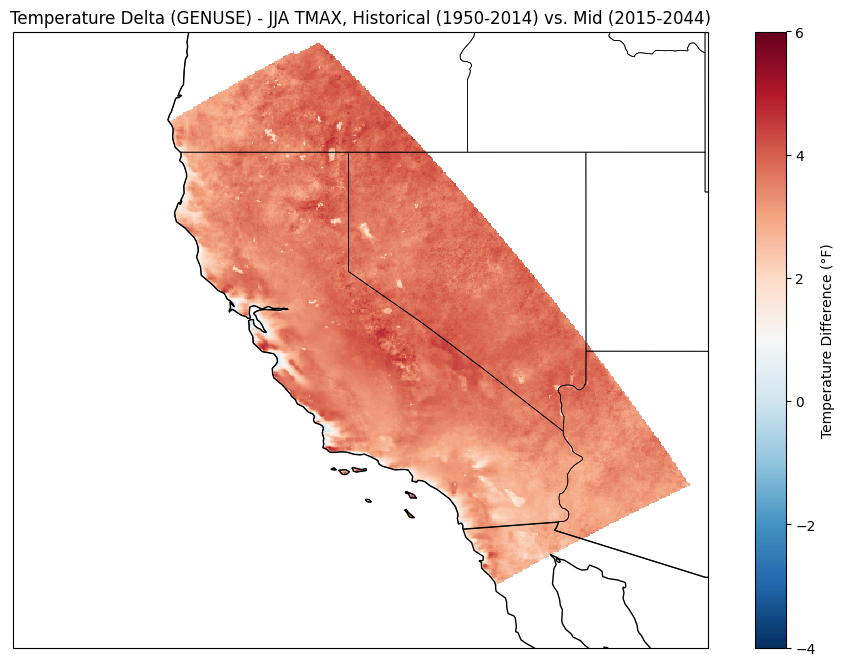

In [58]:
def map_tasmax_difference(netcdf_file, variable_name="tasmax_mean", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the tasmax difference from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the tasmax difference.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax_diff_fahrenheit".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=-4,vmax=6,cbar_kwargs={'label': 'Temperature Difference (°F)'})

        plt.title("Temperature Delta (GENUSE) - JJA TMAX, Historical (1950-2014) vs. Mid (2015-2044)")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_DROUGHT_TMAXJJA_Warming_2015-2044_GENUSEAVE.nc"  # Path to the NetCDF file with the tasmax difference

map_tasmax_difference(netcdf_file_path)

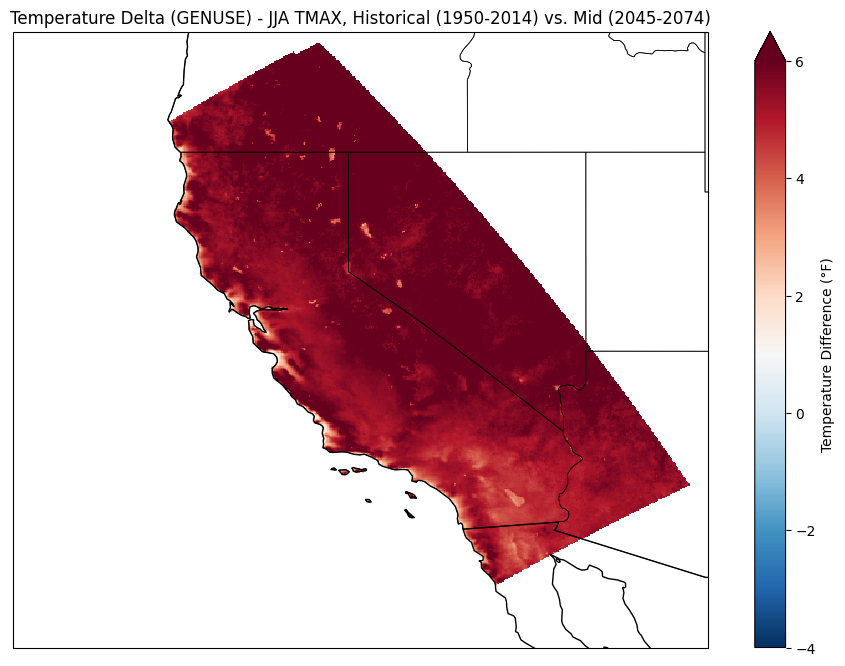

In [60]:
def map_tasmax_difference(netcdf_file, variable_name="tasmax_mean", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the tasmax difference from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the tasmax difference.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax_diff_fahrenheit".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=-4,vmax=6, cbar_kwargs={'label': 'Temperature Difference (°F)'})

        plt.title("Temperature Delta (GENUSE) - JJA TMAX, Historical (1950-2014) vs. Mid (2045-2074)")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_DROUGHT_TMAXJJA_Warming_2045-2074_GENUSEAVE.nc"  # Path to the NetCDF file with the tasmax difference

map_tasmax_difference(netcdf_file_path)